# Multi-Scenario MORDM Gelderland
This Jupyter Notebook uses the model developed by [Ciullo et al. (2019)](https://scholar.google.com/citations?hl=en&user=fDZCVVYAAAAJ&view_op=list_works&sortby=pubdate#d=gs_md_cita-d&u=%2Fcitations%3Fview_op%3Dview_citation%26hl%3Den%26user%3DfDZCVVYAAAAJ%26sortby%3Dpubdate%26citation_for_view%3DfDZCVVYAAAAJ%3AqjMakFHDy7sC%26tzom%3D-120) and the [ema_workbench by Jan Kwakkel](https://github.com/quaquel/EMAworkbench) to evaluate possible strategies for the Gelderland province to increase its resilience to flood risk. It is specifically aimed towards finding optimal strategies for the Gelderland province, namely minimizing casualties and damages across the model runtime in dike rings 1-3 and minimizing dike investment costs for all dike rings. 

## Imports

In [41]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator, Policy)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords, prim


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## General Model Setup
Here, we specify the numbers for the experiment and optimization runs to perform.

In [62]:
# Number of nfes for the Model
n_nfe = 20000

#Number of scenarios for the deep uncertainty evaluation of promising scenarios
n_scenarios = 1000

#Path to the reference scenarios to use for MORDM
path_noaction = "../results/500Scenarios_NoAction_PF1.tar.gz"

## Model Specification

In [2]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(6)
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [4]:
experiments, outcomes = load_results(path_noaction)

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/500Scenarios_NoAction_PF1.tar.gz


In [5]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario

In [14]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=n_nfe, epsilons=[0.1,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 499/5000 nfe
[MainProcess/INFO] generation 10: 997/5000 nfe
[MainProcess/INFO] generation 15: 1495/5000 nfe
[MainProcess/INFO] generation 20: 1994/5000 nfe
[MainProcess/INFO] generation 25: 2491/5000 nfe
[MainProcess/INFO] generation 30: 2991/5000 nfe
[MainProcess/INFO] generation 35: 3485/5000 nfe
[MainProcess/INFO] generation 40: 3983/5000 nfe
[MainProcess/INFO] generation 45: 4480/5000 nfe
[MainProcess/INFO] generation 50: 4980/5000 nfe
[MainProcess/INFO] optimization completed, found 440 solutions
[MainProcess/INFO] terminating pool


In [64]:
results, convergence = results_epsilon_0_1

{'epsilon_progress': array([   0,   40,  353,  609,  832, 1021]),
 'nfe': array([   0,  100, 1196, 2292, 3385, 4480])}

In [15]:
# Save Results
save_results(results_epsilon_0_1, "../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Gelderland.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/5000nfe_BaseCaseMORDM.tar.gz


In [6]:
# Load Results
results_epsilon_0_1 = load_results("../results/"+str(n_nfe)+"nfe_BaseCaseMORDM_Gelderland.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/5000nfe_BaseCaseMORDM.tar.gz


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

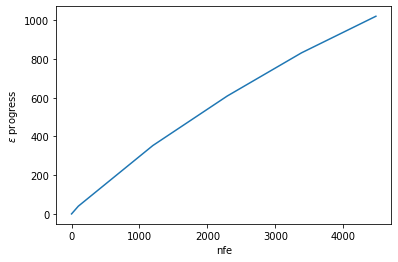

In [65]:
results, convergence = results_epsilon_0_1
convergence = pd.DataFrame(convergence)
plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$ progress')
plt.xlabel('nfe')
plt.show()

## Show tradeoffs in the resulting optimal policies
The algorithm found 440 solutions. 

In [9]:
fig = px.parallel_coordinates(results.iloc[:, 31::], labels= {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", "A3 Expected Annual Damage" : "A3 Damage", "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"}, color=results.index)
fig.update_layout(showlegend=False)
fig.show()

To show the tradeoffs more clearly, we aggregate the costs and the expected number of casualties, as well as the investment costs with the evacuation costs

In [10]:
results_agg = results.iloc[:, 31::]
results_agg["Expected Casualties"] = results_agg["A1_2 Aggr Expected Number of Deaths"] + results_agg["A3 Aggr Expected Number of Deaths"]
results_agg["Expected Damage"] = results_agg["A1_2 Aggr Expected Annual Damage"] + results_agg["A3 Expected Annual Damage"]
results_agg["Traditional Costs"] = results_agg["A1_5 Dike Investment Costs"] + results_agg["Evacuation Costs"]


In [11]:
fig = px.parallel_coordinates(results_agg, dimensions=["Expected Casualties","Expected Damage", "Traditional Costs", "Room for River Investment Costs"], color = results_agg.index)
fig.update_layout(showlegend=False)
fig.show()

## Re-Evaluate under deep uncertainty
For evaluating the promising policies under deep uncertainty, we set a hard limit on one expected casualties below 0.001 and expected damages below €100.000. 

In [12]:
results_subset = results[
    ((results["A1_2 Aggr Expected Number of Deaths"] + results["A3 Aggr Expected Number of Deaths"]) < 0.001) &
    ((results["A1_2 Aggr Expected Annual Damage"] + results["A3 Expected Annual Damage"]) < 100000) ]

We further use the remaining policies to test them under deep uncertainty by running the policies for 1000 scenarios each. 

In [13]:
policies = results_subset.iloc[:,0:31]
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [14]:
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 8 policies * 1 model(s) = 800 experiments
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 640 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
#Save results
save_results(results, "../results/DeepUncertainty8policies_"+str(n_scenarios)+"scenarios_Gelderland.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/DeepUncertainty8policies_100scenarios.tar.gz


### Signal-to-noise Ratio
To find the most robust policy, we rate the different policies by calculating the signal-to-noise ratio. 

In [16]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [18]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A1_2 Aggr Expected Annual Damage,A3 Expected Annual Damage,A1_2 Aggr Expected Number of Deaths,A3 Aggr Expected Number of Deaths,A1_5 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
204,4.472636e+16,0.000000e+00,2.573116e-04,0.000000e+00,0.000000,0.0,4.525318e+07
233,1.365190e+14,4.036240e+10,8.806247e-07,2.888055e-09,1248.725219,0.0,6.458915e+06
3,1.161959e+16,8.859493e+11,3.926526e-03,4.259212e-06,0.000000,0.0,0.000000e+00
37,9.774457e+16,6.466628e+09,5.754004e-04,6.898292e-10,846.014153,0.0,1.642842e+07
426,2.670241e+16,1.397414e+12,1.310495e-04,6.288404e-08,0.000000,0.0,6.481137e+07
55,3.899681e+11,3.348941e+12,9.875552e-09,2.919997e-07,0.000000,0.0,1.465498e+06
64,1.323409e+16,3.932125e+11,5.831596e-03,9.392162e-07,0.000000,0.0,0.000000e+00
92,9.621311e+16,8.357226e+07,5.483846e-04,8.323510e-12,0.000000,0.0,2.310815e+08


In [36]:
fig = px.parallel_coordinates(scores, labels= {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", "A3 Expected Annual Damage" : "A3 Damage", "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"})
fig.show()

### Maximum Regret
Another robustness criterion is the maximum regret measure. We again calculate this measure for every policy selected

In [31]:
def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data.pivot(index='scenario', columns='policy')
    
    data.columns = data.columns.get_level_values(1)
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

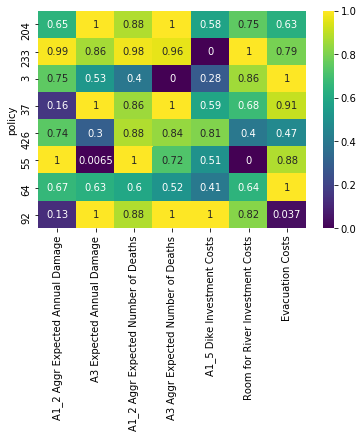

In [32]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [37]:
fig = px.parallel_coordinates(max_regret, labels= {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", "A3 Expected Annual Damage" : "A3 Damage", "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"})
fig.show()

## Scenario Discovery
We perform Scenario Discovery using the PRIM-algorithm to discover such scenarios in which the robust policies fail. We focus on such scenarios where death and damages occur.

In [54]:
x = experiments.iloc[:,0:19]

outcomes["selection"] = outcomes["A1_2 Aggr Expected Annual Damage"] + outcomes["A3 Expected Annual Damage"] + outcomes["A1_2 Aggr Expected Number of Deaths"] + outcomes["A3 Aggr Expected Number of Deaths"]

y =  outcomes["selection"] > 0 
prim_alg = prim.Prim(x,y, threshold=0.5)
box = prim_alg.find_box()

[MainProcess/INFO] 800 points remaining, containing 171 cases of interest
[MainProcess/INFO] mean: 0.9285714285714286, mass: 0.07, coverage: 0.30409356725146197, density: 0.9285714285714286 restricted_dimensions: 11


In [55]:
box.inspect_tradeoff()


alt.VConcatChart(...)

We select box 29, as it shows a good mixture between coverage and density

In [56]:
box.inspect(29)


coverage    0.532164
density       0.8125
id                29
mass            0.14
mean          0.8125
res_dim           10
Name: 29, dtype: object

                                  box 29                   \
                                     min              max   
A.1_pfail                      0.0074895         0.436431   
A.2_pfail                     0.00776894         0.793631   
A.4_Bmax                         31.6977          323.838   
A.4_pfail                     0.00792484         0.916731   
A.5_pfail                      0.0095941         0.877756   
A.0_ID flood wave shape             19.5            109.5   
A.3_Bmax                         49.9373          348.098   
A.1_Bmax                         43.7311          316.981   
discount rate 1          {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}   
A.2_Bmax                         49.6749          333.839   

                                                                     
                                              

In [58]:
box.select(29)
scens_in_box = experiments.iloc[box.yi]
outcomes_in_box = {k:v[box.yi] for k,v in outcomes.items()}
#Save results
save_results((scens_in_box, outcomes_in_box), '../results/mordm_29_Gelderland.tar.gz')

# Multi-Scenario MORDM
Based on the results of scenario discovery, we now continue to select three of such scenarios based on the worst outcomes in terms of casualties, damages and total costs. We will take each of these scenarios as a reference scenario to run an optimization algorithm for the levers to choose. 